#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [4]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score

     |████████████████████████████████| 1.5MB 4.4MB/s 
     |████████████████████████████████| 2.9MB 11.1MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=587708935a41cef1f6424346edd55e7d54aa809a8c65baf2a7a213c0a29cfc8f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 4.4MB/s 
     |████████████████████████████████| 163kB 4.4MB/s 
     |████████████████████████████████| 17.7MB 204kB/s 
     |████████████████████████████████| 245kB 43.3MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### **Config**

In [13]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [14]:
MODEL = 'bart'
MODELS = {}

In [15]:
# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_moc/assign_bullets/bart/'

    OUTPUT_PATH = drive_dir+'summarization/assign_bullets_moc/bart/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_moc/assign_bullets/pegasus/'

    OUTPUT_PATH = drive_dir+'summarization/assign_bullets_moc/pegasus/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

### **Init**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill

### **Function Definition**

##### Import Model and Tok

In [9]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [10]:
def print_example(idx, text, summ, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [11]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, row.bullets)

##### Plot Evaluation

In [12]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))

    fig, ax = plt.subplots(figsize=(10, 6))
    box_plt_list = [plt.boxplot(
        [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for r in prf],
        positions= xticks+var,
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)\
        for rouge, var in zip(config.ROUGE_TYPES,
            np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge))]

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Assign Bullets Merge or Chunk**

In [16]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print**

##### Print Train Examples

In [18]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[*] importing the model




[+] the model is now present in cache

(9781912776696, 'hh-5')
Median overall survival. The Kaplan-Meier curves can be used to obtain median survival times (Figure 2.3). The median survival time is the time point
at which 50% of patients are estimated to be alive, and this can be found by drawing a horizontal line at the 50% line on the y -axis. Hazard ratio.
Treatment differences are usually expressed as a hazard ratio (HR). In order to understand what an HR is, it is necessary to understand what a hazard
rate is. Hazard rate is the probability that a subject will die within a given time interval among the subjects alive in that treatment group at the
start of that interval. In a group of 1000 patients, suppose 10 die in month 1, 15 die in month 2 and 12 die in month 3. The hazard rate for month 1 =
10/1000. The hazard rate for month 2 = 15/990. The hazard rate for month 3 = 12/975 and so on. In practice, hazard rates can be calculated for smaller
time periods and the hazard rate can

##### Print Val Examples

In [19]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Anatomic structures involved in generating pain. Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin. Mechanical disorders of the lumbar spine are related to
injury, overuse or deformity of a spinal structure. The most important traumatic factors in low back pain relate to soft tissue structures. Precise
identification of the injured tissue, and the role of that injury in the consequent pain and dysfunction, can be frustratingly difficult. Problems
occur in muscles, intervertebral discs, facet joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different decades of life. Early in life, muscle injuries are more
frequent, while joint problems occur in the sixth decade

##### Print Test Examples

In [20]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
Modern antiepileptic drugs. After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep brain stimulator -
have received licenses for the adjunctive treatment of refractory epilepsy, the last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG,
levetiracetam (LEV), oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely available for partial seizures.
Rufinamide (RFN) has been licensed in Europe and the USA for adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate
(ESL) is licensed in Europe as adjunctive treatment for partial seizures with or without secondary generalization. Retigabine (RTG; ezogabine in the
USA) and perampanel (PER) have recently been approved for use in Europe and the USA for the same indication. After 20 years of global experience,
vigabatrin (VGB) has been approved in the USA for the tre

### **Summarization**

##### Summarize Test

In [21]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [22]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [01:53<00:00,  4.54s/it]


### **Evaluation**

In [23]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [24]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [25]:
df_test = evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

##### Plot Evaluation

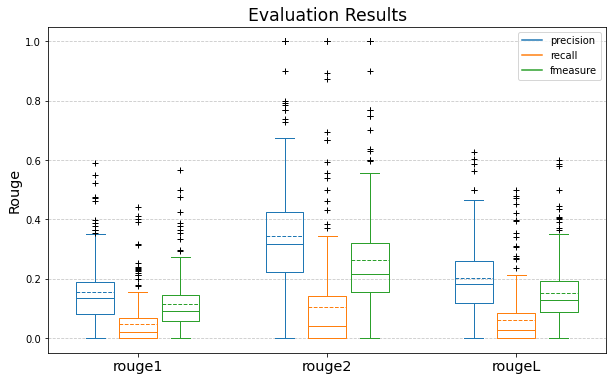

In [26]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')